In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

df = pd.read_csv("wine.csv", index_col=['month'], parse_dates=['month'], dayfirst=True, encoding="ISO-8859-1")
print(df.shape)
df.head()



(176, 1)


,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


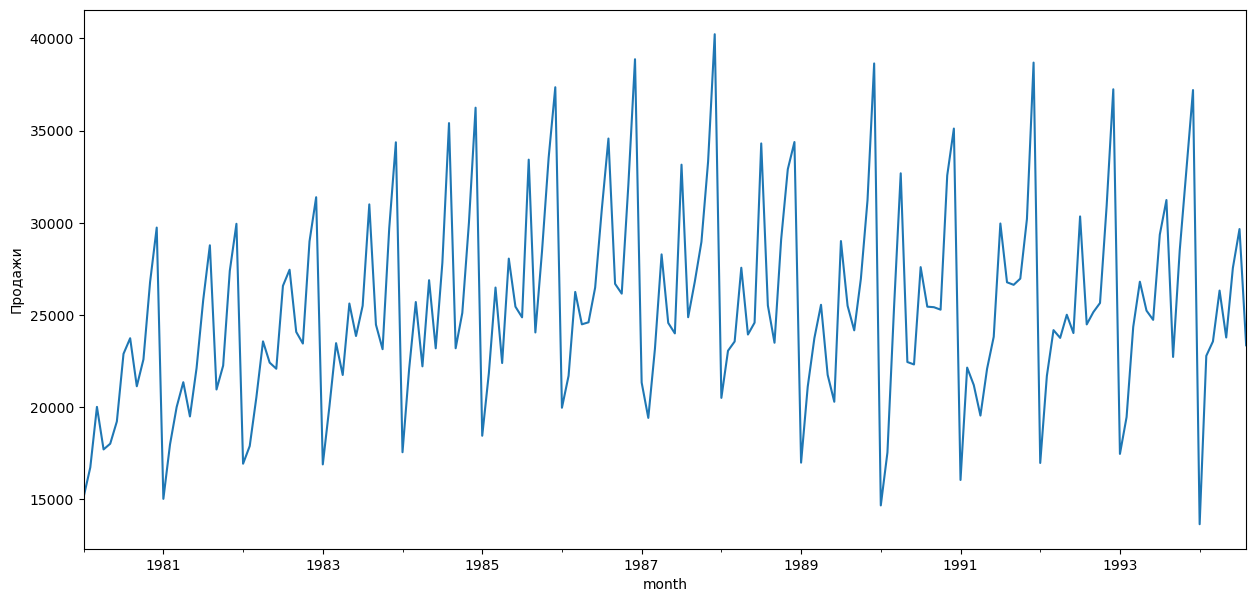

In [9]:
# выведем данные на график
plt.figure(figsize=(15,7))
df['sales'].plot()
plt.ylabel('Продажи')
plt.show()

Критерий Дики-Фуллера: p=0.051161


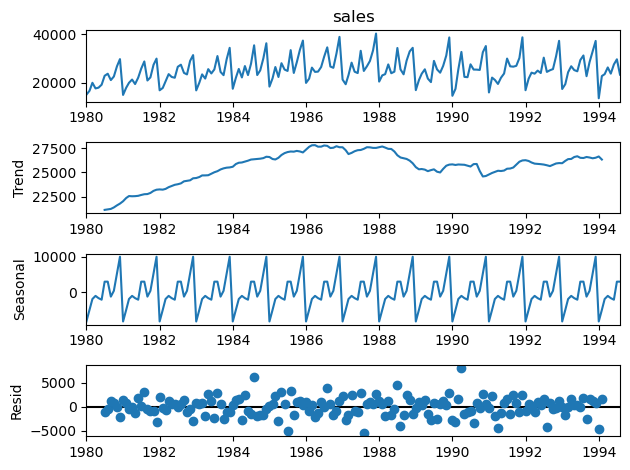

In [11]:
# Проверьте стационарность ряда
sm.tsa.seasonal_decompose(df['sales']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['sales'])[1])

По критерию Дики-Фуллера гипотеза о нестационарности ряда не отвергается. Значение 0.051161 больше порога 0.05.

Немного видны следующие особенности данных:
возрастающий тренд
Не очень стабильная дисперсия (В начале в течение года данные не очень сильно изменялись. А под конец максимальный замер уже отличается от минимального)
Сезонность (Замеры раз в 12 месяцев сильно похожи друг на друга. Например, пики на графики были записаны в один и тот же месяц)
заметная структура остатков

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


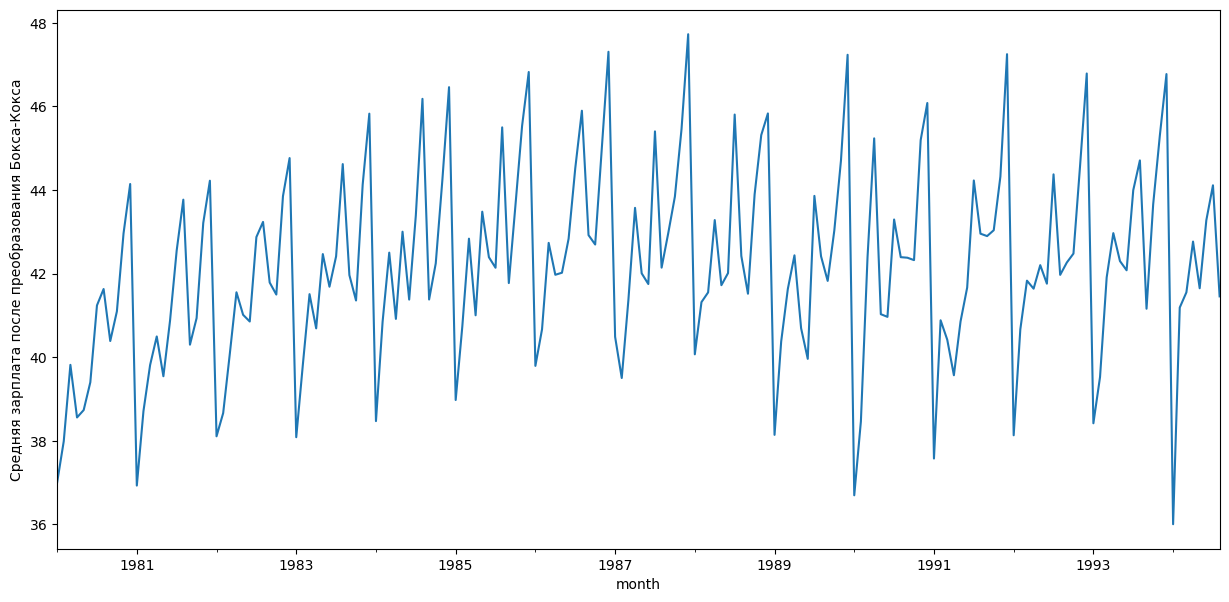

In [23]:
df['sales_box'], lmbda = stats.boxcox(df['sales'])
plt.figure(figsize=(15,7))
df['sales_box'].plot()
plt.ylabel(u'Средняя зарплата после преобразования Бокса-Кокса')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['sales_box'])[1])

Критерий Дики-Фуллера отвергает гипотезу не стационарности, но визуально в
данных виден тренд.

Выведем сразу два графика - оригинальный и после Кокса-Бокса:

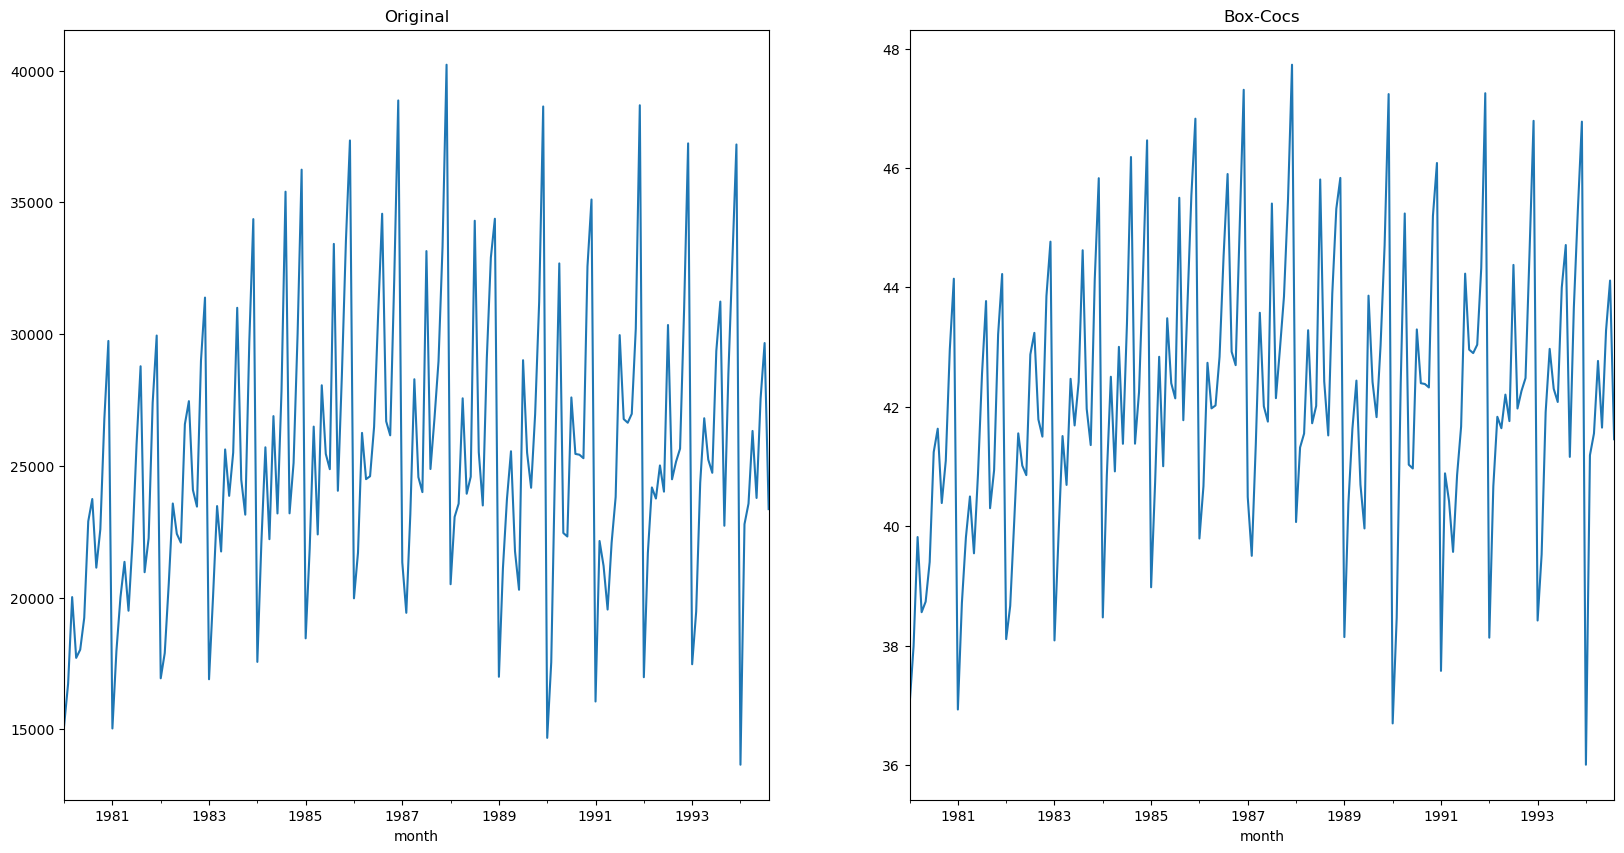

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

df['sales'].plot(kind='line', ax=ax[0])
df['sales_box'].plot(kind='line', ax=ax[1])

ax[0].set_title('Original')
ax[1].set_title('Box-Cocs')

plt.show()

Попробуйте сезонное дифференцирование, на продифференцированном ряде проверьте стационарность.

Критерий Дики-Фуллера: p=0.128317


<Figure size 1500x1000 with 0 Axes>

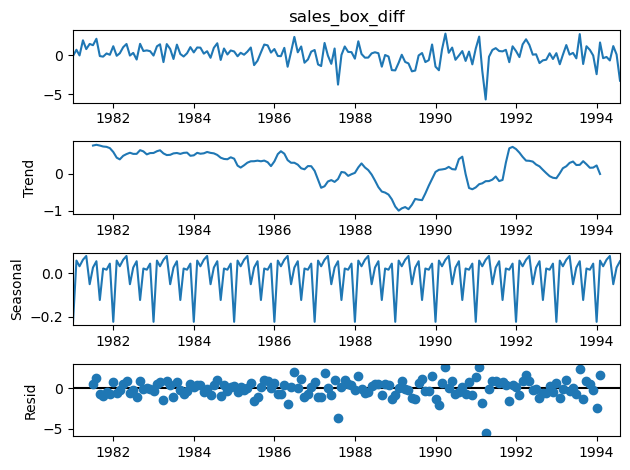

In [24]:
df['sales_box_diff'] = df['sales_box'] - df['sales_box'].shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df['sales_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['sales_box_diff'][12:])[1])

По критерию Дики-Фуллера нельзя отвергнеть гипотезу нестационарности (0.128317 > 0.05), в остатках стало заметно меньше структуры, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000002


<Figure size 1500x1000 with 0 Axes>

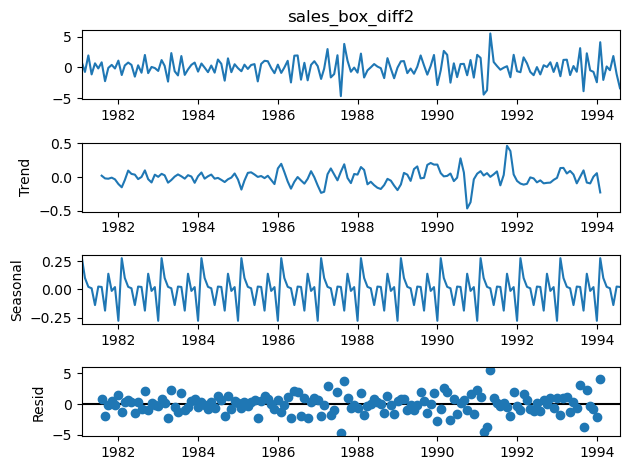

In [25]:
df['sales_box_diff2'] = df['sales_box_diff'] - df['sales_box_diff'].shift(1)
plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(df['sales_box_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['sales_box_diff2'][13:])[1])

По критерию Дики-Фуллера можно отвергнеть гипотезу нестационарности (0.000002 < 0.05), в остатках заметна структура, избавиться от тренда удалось.

Для подбора модели постройте ACF и PACF полученного ряда. Возьмите
начальные приближение параметров модели. Постройте модель, проверьте ее
остатки на стационарность. (3 балла)

/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


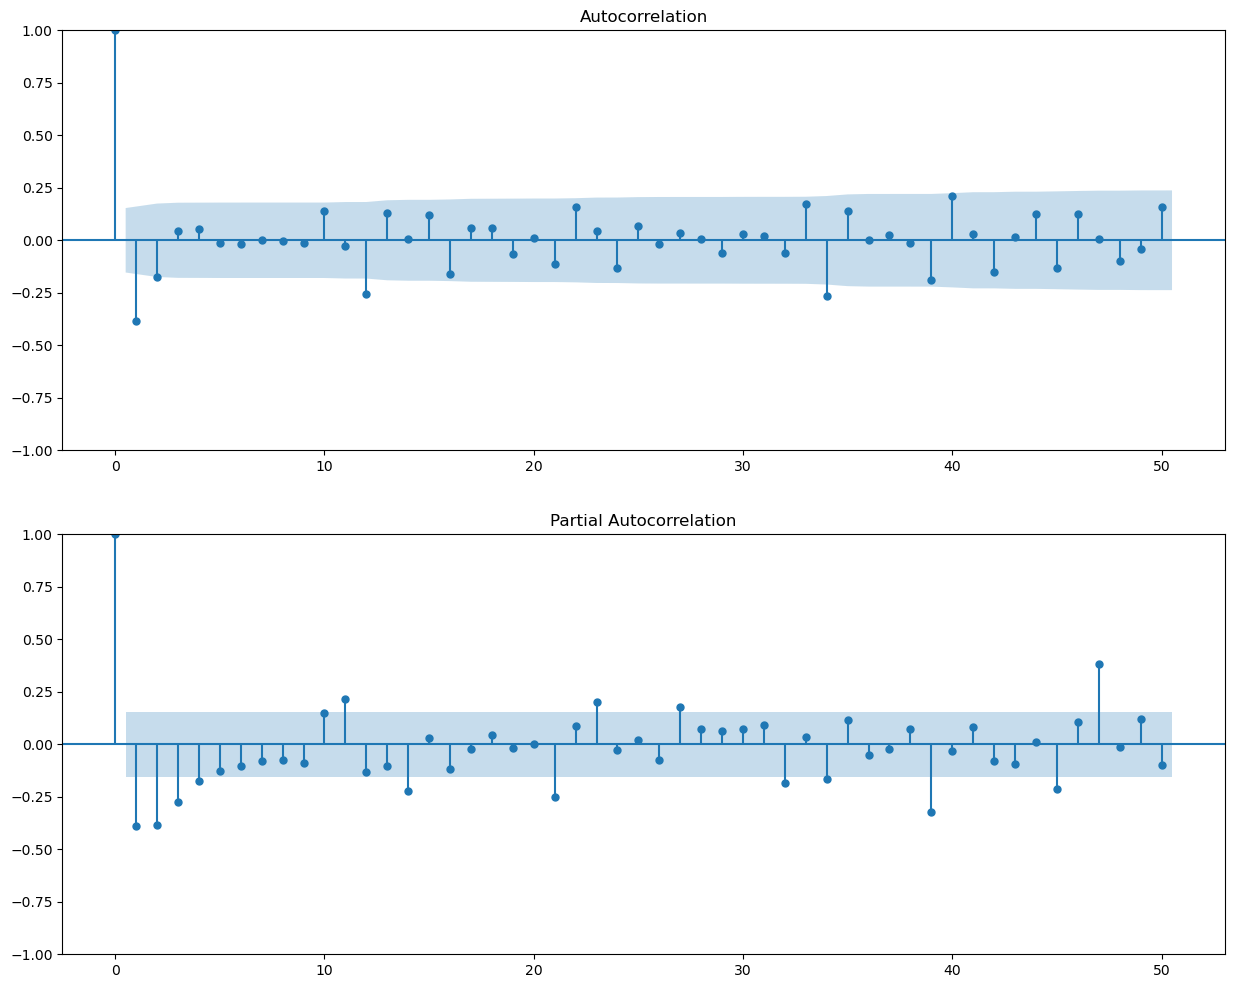

In [29]:
plt.figure(figsize=(15,12))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['sales_box_diff2'][13:].values.squeeze(), lags=50, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['sales_box_diff2'][13:].values.squeeze(), lags=50, ax=ax)
plt.show()

Выбираем параметры нашей модели:

__Q__ - значение последнего значимого сезонного лага на автокоррелограмме ACF. Т.к. значимый лаг, кратный периоду (12) один, то __Q = 1__

__q__ - значение последнего значимого несезонного лага на автокоррелограмме, меньшего величин периода __q = 10__

__P__ - значение последнего значимого сезонного лага на частичной автокоррелограмме PACF. В данном случае это лаг = 12, поэтому возьмем значение __P = 1__

__p__ - значение последнего значимого несезонного лага, меньшего величин периода, на частичной автокоррелограмме. __p = 10__


Начальные приближения: Q=1, q=10, P=1, p=10

In [30]:
p = 10
d = 1  # столько раз делали дифференциорование
q = 10
P = 1
D = 1  # столько раз делали сезонное дифференцирование
Q = 1

In [31]:
model=sm.tsa.statespace.SARIMAX(df['sales_box'], order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit(disp=-1)

/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Критерий Дики-Фуллера: p=0.000000


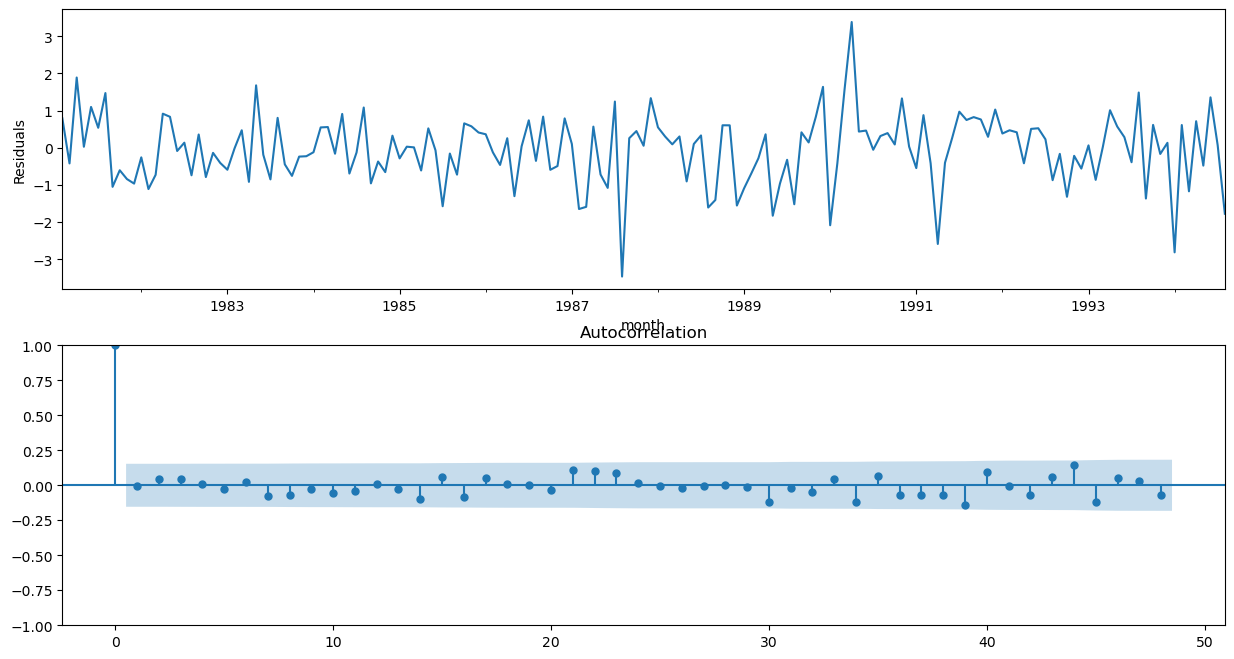

In [32]:
plt.figure(figsize=(15, 8))
plt.subplot(211)
model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

Неплохо. Но возможно, стоит перебрать больше значений параметров для поиска оптимальной модели? Обычно после примерного определения значений параметров модели, проводят grid search по наборам близких к оптимальным значений.

In [34]:
from itertools import product

#устанавливаем границы массивов наших параметров
ps = range(10, 12)
d=1
qs = range(10, 12)
Ps = range(0, 2)
D=1
Qs = range(1, 2)

# столько комбинаций параметров будем перебирать
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8